In [5]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


## Generate Data
from scipy.integrate import ode
alpha  = 1
beta=0.1
gamma=1.5
delta=0.75 * 0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha*state[0] -   beta*state[0]*state[1],
                  -gamma*state[1] + delta*state[0]*state[1]])

t = np.linspace(0, 24,  50)              # time
X0 = np.array([10, 5])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y

np.random.seed(0)
yobs = X.T * np.random.lognormal(mean=0,sigma=0.1,size=X.T.shape)  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
times = t
print(yobs.std(axis=0))
yobs_norm = yobs / yobs.std(axis=0)



## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 + p.pn[10] - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 + p.pn[11] - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}


d = 12

model_sunode = pm.Model()

with model_sunode:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    xi = pm.Bernoulli('xi', 0.8, shape=d)
    pnss = pm.Deterministic('pnss', pn * xi)
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pnss,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])

with model_sunode:

    start = pm.find_MAP()

    # Initialize parameters with least squares and all other values with MAP
    inp = yobs_norm
    u = inp[:,0]
    v = inp[:,1]

    θ = np.array([u,v,u*v,u**2,v**2,np.ones(u.shape)]).T

    import pysindy as ps
    from pysindy.differentiation import SmoothedFiniteDifference
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    dx = sfd(inp)

    guess = np.linalg.lstsq(θ,dx)[0]
    
    print('Initialization')
    print(guess)

    start['pn'] = guess.flatten()
    start['pnss'] = start['pn']
    start['xi'] = np.ones(start['pn'].shape).astype(int)
    start['y0'] = yobs_norm[0,:]
    start['y0_log__'] = np.log(start['y0'])

    #trace = pm.sample(4000, tune=2000, cores=2, start=start,random_seed=0,step_kwargs={'nuts':{'target_accept':0.95}})

    trace = pm.backends.load_trace('synthetic_ss_12param' + '.trace',model_sunode)




    





[10.94487607  6.80885278]


logp = -150.16, ||grad|| = 20.741: 100%|██████████| 51/51 [00:00<00:00, 118.22it/s]   
/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:95: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Initialization
[[-0.00799787  0.08987216]
 [-0.75074696 -0.5146038 ]
 [-0.12253869  0.21118045]
 [ 0.050315    0.02684945]
 [ 0.12290753  0.0284561 ]
 [ 0.84539028 -0.19105767]]


In [6]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
pn[0],0.973,0.189,0.653,1.230,0.026,0.019,52.0,52.0,71.0,25.0,1.07
pn[1],-0.019,1.259,-2.887,2.308,0.027,0.032,2209.0,752.0,1788.0,2216.0,1.03
pn[2],-0.014,1.219,-2.513,2.460,0.067,0.062,334.0,195.0,339.0,283.0,1.03
pn[3],-1.464,0.143,-1.794,-1.266,0.033,0.024,19.0,18.0,23.0,13.0,1.06
pn[4],-0.690,0.097,-0.843,-0.500,0.012,0.008,67.0,67.0,74.0,126.0,1.02
pn[5],0.797,0.099,0.627,0.998,0.024,0.017,17.0,17.0,19.0,15.0,1.07
pn[6],-0.085,1.104,-2.343,2.086,0.093,0.066,140.0,140.0,117.0,74.0,1.12
pn[7],-0.129,1.272,-2.563,2.489,0.068,0.050,353.0,324.0,310.0,520.0,1.01
pn[8],-0.010,1.269,-2.431,2.639,0.028,0.037,2079.0,600.0,1138.0,633.0,1.04
pn[9],-0.234,1.523,-3.700,2.336,0.154,0.109,98.0,98.0,109.0,68.0,1.03


<bound method Axes.plot of <matplotlib.axes._subplots.AxesSubplot object at 0x7f0ff001f210>>

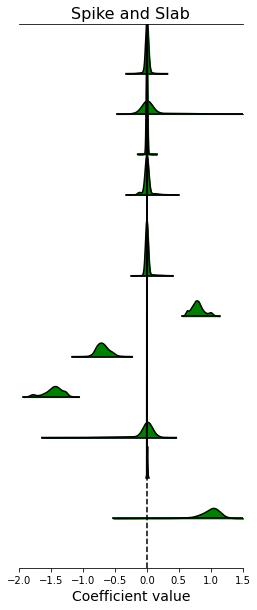

In [14]:
plt.figure(figsize=(4,10))
ax = plt.subplot(1,1,1)
ax.plot([0, 0], [-0.05, 0.5], 'k--')
pm.forestplot((trace['pnss']).T, credible_interval=0.95, kind='ridgeplot', colors='green', ridgeplot_overlap=10, ax=ax)
#ax.set_title('')
#ax.set_xlabel('Coefficient value')
#ax.set_ylabel('Coefficient')
ax.set_xlim(-2, 1.5)
ax.set_ylim(-0.05, 0.5)
#ax.set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85)
#ax.set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'], fontsize=16)

ax.set_xlabel('Coefficient value', fontsize=14)
plt.title('Spike and Slab', fontsize=16)
plt.yticks([])    
ax.plot